<a href="https://colab.research.google.com/github/Leegyu66/GoogLeNet/blob/main/googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch import nn
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from tqdm import tqdm
import numpy as np
import cv2

In [2]:
class InceptionBlock(nn.Module):
  def __init__(self, in_channels, feature_maps):
    super(InceptionBlock, self).__init__()
    self.relu = nn.ReLU()
    self.p1 = nn.Sequential(nn.Conv2d(in_channels, feature_maps[0], kernel_size=1, stride=1, padding=0), self.relu)
    self.p2 = nn.Sequential(nn.Conv2d(in_channels, feature_maps[1], kernel_size=1, stride=1, padding=0), self.relu,
                            nn.Conv2d(feature_maps[1], feature_maps[2], kernel_size=3, stride=1, padding=1), self.relu)
    self.p3 = nn.Sequential(nn.Conv2d(in_channels, feature_maps[3], kernel_size=1, stride=1, padding=0), self.relu,
                            nn.Conv2d(feature_maps[3], feature_maps[4], kernel_size=5, stride=1, padding=2), self.relu)
    self.p4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                            nn.Conv2d(in_channels, feature_maps[5], kernel_size=1, stride=1, padding=0))

  def forward(self, x):
    out1 = self.p1(x)
    out2 = self.p2(x)
    out3 = self.p3(x)
    out4 = self.p4(x)

    return torch.cat((out1, out2, out3, out4), axis=1)

class Aux(nn.Module):
  def __init__(self, in_channels, classes):
    super(Aux, self).__init__()
    in_features = 4*4*128
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()
    self.AvPool = nn.AvgPool2d(kernel_size=5, stride=3)
    self.Conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=in_features, out_features=in_features)
    self.fc2 = nn.Linear(in_features=in_features, out_features=classes)

  def forward(self, x):
    x = self.AvPool(x)
    x = self.relu(self.Conv(x))
    x = self.flatten(x)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

class GoogLeNet(nn.Module):
  def __init__(self):
    super(GoogLeNet, self).__init__()
    classes = 10
    in_channels = [192, 256, 480, 512, 512, 512, 528, 832, 832]
    feature_maps = [[64, 96, 128, 16, 32, 32],
                  [128, 128, 192, 32, 96, 64],
                  [192, 96, 208, 16, 48, 64],
                  [160, 112, 224, 24, 64, 64],
                  [128, 128, 256, 24, 64, 64],
                  [112, 144, 288, 32, 64, 64],
                  [256, 160, 320, 32, 128, 128],
                  [256, 160, 320, 32, 128, 128],
                  [384, 192, 384, 48, 128, 128]]

    self.relu = nn.ReLU()
    self.Conv7x = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3) # reduce 224x224 -> 112x112
    self.MaxPool3x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.LocalNorm = nn.LocalResponseNorm(size=5)
    self.Conv1x = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0)
    self.Conv3x = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)

    self.Blocks = nn.ModuleList([InceptionBlock(in_channels[i], feature_maps[i]) for i in range(len(in_channels))])

    self.Aux1 = Aux(512, classes)
    self.Aux2 = Aux(528, classes)

    self.AvgPoolx = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)
    self.Dropoutx = nn.Dropout(0.4)
    self.fc1 = nn.Linear(1024, classes)

  def forward(self, x):
    outputs = []
    x = self.relu(self.Conv7x(x))
    x = self.MaxPool3x(x)
    x = self.LocalNorm(x)
    x = self.relu(self.Conv1x(x))
    x = self.relu(self.Conv3x(x))
    x = self.LocalNorm(x)
    x = self.MaxPool3x(x)

    for i, block in enumerate(self.Blocks):
      if i == 2 or i == 7:
        x = self.MaxPool3x(x)
      if i == 3:
        outputs.append(self.Aux1(x))
      elif i == 6:
        outputs.append(self.Aux2(x))

      x = block(x)

    x = self.AvgPoolx(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    outputs.append(x)

    return outputs

In [3]:
Inception = GoogLeNet()
outs = Inception(torch.rand(16, 3, 224, 224))
for out in outs:
  print(out.shape)

torch.Size([16, 10])
torch.Size([16, 10])
torch.Size([16, 10])


In [4]:
import torch.nn.functional as F

epochs = 20
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
loss = 0

data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=data_transforms['train']
)

testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=data_transforms['val']
)

data_length = len(trainset)
train_length, valid_length = int(data_length*0.8), int(data_length*0.2)

train_dataset, valid_dataset = random_split(trainset, [train_length, valid_length])


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=True)

# model = Lenet(in_channels=in_channels, feature_maps=feature_maps, classes=10).to(device)
model = GoogLeNet().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

criterion = nn.MultiLabelSoftMarginLoss().cuda()


for epoch in range(epochs):
  losses = []
  for i, data in tqdm(enumerate(train_loader), desc=f"Epoch: {epoch:03d}"):
    cost = 0
    inputs, labels = data
    inputs = torch.Tensor(inputs).to(device)
    labels = torch.Tensor(labels).to(device)
    labels = F.one_hot(labels, num_classes=10)

    optimizer.zero_grad()

    pred = model(inputs)
    pred1, pred2, pred3 = pred[0], pred[1], pred[2]

    loss1 = criterion(pred1, labels)
    loss2 = criterion(pred2, labels)
    loss3 = criterion(pred3, labels)

    loss = loss1*0.3 + loss2*0.3 + loss3

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
  print(np.mean(losses))
  torch.save(model, f"./model{epoch}.h5")

100%|██████████| 170498071/170498071 [00:12<00:00, 13155420.54it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Epoch: 000: 625it [01:22,  7.59it/s]


0.4972380997657776


Epoch: 001: 625it [01:19,  7.82it/s]


0.42943718972206113


Epoch: 002: 625it [01:19,  7.84it/s]


0.3976411973953247


Epoch: 003: 625it [01:19,  7.82it/s]


0.36772091464996337


Epoch: 004: 625it [01:20,  7.81it/s]


0.34239768018722533


Epoch: 005: 625it [01:20,  7.81it/s]


0.32367064023017883


Epoch: 006: 625it [01:19,  7.84it/s]


0.3095755968809128


Epoch: 007: 625it [01:19,  7.83it/s]


0.29772745263576506


Epoch: 008: 625it [01:19,  7.83it/s]


0.28819697382450105


Epoch: 009: 625it [01:19,  7.82it/s]


0.279314820933342


Epoch: 010: 625it [01:20,  7.81it/s]


0.27150783026218417


Epoch: 011: 625it [01:19,  7.82it/s]


0.2649074415445328


Epoch: 012: 625it [01:19,  7.82it/s]


0.2575050138473511


Epoch: 013: 625it [01:20,  7.79it/s]


0.2518394736289978


Epoch: 014: 625it [01:19,  7.84it/s]


0.24853754053115845


Epoch: 015: 625it [01:19,  7.82it/s]


0.24395599620342254


Epoch: 016: 625it [01:19,  7.83it/s]


0.24077872097492217


Epoch: 017: 625it [01:19,  7.83it/s]


0.23363730022907256


Epoch: 018: 625it [01:19,  7.84it/s]


0.23257938570976258


Epoch: 019: 625it [01:19,  7.82it/s]


0.23081538939476012


In [61]:
correct = 0
total = 0

model.to(device)
model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)[0]
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


Files already downloaded and verified
Files already downloaded and verified


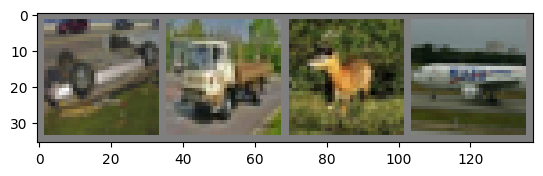

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision

transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.RandomResizedCrop(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data = iter(trainloader)
image, label = next(data)

matrix = np.random.rand(32, 32, 3)
imshow(torchvision.utils.make_grid(image))